In [181]:
import math
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

!nvidia-smi

Fri Jun  9 17:40:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:15:00.0 Off |                    0 |
| N/A   30C    P0    53W / 300W |   5977MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [182]:
# Dispositivo onde tensores serão criados, armazenados e processados
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Randon Seed fixa para resultados reprodutíveis
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

cuda:0


## Data Loader

In [183]:
class WellLoader(Dataset):
    
    def __init__(self, 
                 path, 
                 wells, 
                 var_in, 
                 var_out, 
                 normalizing_split=0.2, 
                 normalizer=RobustScaler, 
                 max_sequence=16, 
                 step=1):
        
        self.path = path
        with open(self.path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())
        self.wells = wells
        self.var_in = var_in
        self.var_out = var_out
        self.normalizing_split = normalizing_split
        self.normalizer = normalizer
        self.max_sequence = max_sequence
        self.step = step
        self.batches_X = None
        self.batches_Y = None
        self.outputs = None
        self.normalizers = []
        
        indexes = self.get_wells_index(self.wells)
        self.load_data_by_index(indexes)
        
    def get_wells_index(self, wells):
        
        indexes = []
        for well, filt in wells:
            indexes.extend([(meta['INDEX'], filt) for meta in self.metadata if meta['WELL'] == well])
        return indexes
    
    def load_data_by_index(self, indexes):
        
        batches_X = []
        batches_Y = []
        outputs = []
        for index, filt in indexes:
            data = pd.read_json(f'{self.path}/{index}.json')#.reset_index()
            # Armengue: Por liq vol para preencher o dataset
            data['BORE_LIQ_VOL'] = data['BORE_OIL_VOL'] + data['BORE_WAT_VOL']
            data = data[self.var_in + self.var_out].dropna().reset_index(drop=True)
            X = data[self.var_in].values[filt,:]
            Y = data[self.var_out].values[filt,:]
            #X_base, _, Y_base, _ = train_test_split(X, Y, test_size = self.normalizing_split)
            #scaler_X = self.normalizer().fit(X_base)
            #scaler_Y = self.normalizer().fit(Y_base)
            #self.normalizers.append((scaler_X, scaler_Y))
            #X, Y = scaler_X.transform(X), scaler_Y.transform(Y)
            X, Y = torch.from_numpy(X.astype('float32')), torch.from_numpy(Y.astype('float32'))
            output = Y[self.max_sequence::self.step]
            #print(Y.shape)
            #X = torch.split(X, self.max_sequence, dim= 0)
            #Y = torch.split(Y, self.max_sequence, dim= 0)
            X = X.unfold(0,self.max_sequence, self.step)
            Y = Y.unfold(0,self.max_sequence, self.step)
            batches_X.append(X)
            batches_Y.append(Y)
            outputs.append(output)
            #print(X.shape)
        self.batches_X = torch.concat(batches_X, axis=0)
        self.batches_Y = torch.concat(batches_Y, axis=0)
        self.outputs = torch.concat(outputs, axis=0)
            
    def __len__(self):
        
        return self.outputs.shape[0]
    
    def __getitem__(self, idx):
                        
        srcs = self.batches_X[idx,:,:]
        trgts = self.batches_Y[idx,:,:]
        output = self.outputs[idx,:]
        
        return srcs, trgts, output
        
        
                 

In [184]:
path = './dataset/volve'
wells = [
    ('15/9-F-1 C', slice(28, None)),
]

var_in = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

var_out = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


dataset = WellLoader(path, wells, var_in, var_out, max_sequence = 16)

In [185]:
class SubsetSplitter:
    
    def __init__(self, batch_size, validation_split, test_split, shuffle=False):
        
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.test_split = test_split
        self.shuffle = shuffle
        
    def __call__(self, dataset:Dataset):
        
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = int(np.floor(self.validation_split * dataset_size))
        test_split = int(np.floor(self.test_split * dataset_size))
        train_split = dataset_size - validation_split - test_split
        if self.shuffle :
            np.random.shuffle(indices)
        train_indices = indices[:train_split]
        validation_indices = indices[train_split:train_split + validation_split]
        test_indices = indices[train_split + validation_split:]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(validation_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, 
                                                   sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=valid_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=test_sampler)
        
        return train_loader, validation_loader, test_loader

In [186]:
splitter = SubsetSplitter(8, 0.2, 0.2)
train_loader, validation_loader, test_loader = splitter(dataset)

## Model definition

In [187]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
    
positional_encoding = PositionalEncoding(dim_model = 10, dropout_p=0.3, max_len=1200)
tensor = torch.zeros((1,2,10))
tensor
encoded = positional_encoding(tensor)
encoded

tensor([[[0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 0.0000,
          0.0000, 1.4286]]])

In [188]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_outputs,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        num_linear_layers=0,
        norm_first=False
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        #self.embedding = nn.Embedding(num_outputs, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p, 
            batch_first=True,
            norm_first = norm_first
        )
        self.linear_layers = nn.ModuleList()
        for i in range(num_linear_layers):
            self.linear_layers.append(nn.Linear(dim_model, dim_model))
            self.linear_layers.append(nn.ReLU6())
        self.out = nn.Linear(dim_model, num_outputs)
        self.bias_layer = nn.Linear(dim_model, dim_model)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src_corr = src #* math.sqrt(self.dim_model)
        tgt_corr = tgt #* math.sqrt(self.dim_model)
        #src_corr = self.positional_encoder(src_corr)
        #tgt_corr = self.positional_encoder(tgt_corr)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        #src = src.permute(1,0,2)
        #tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src_corr, tgt_corr, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        for linear in self.linear_layers:
            transformer_out = linear(transformer_out)
        out = transformer_out
        
        #recuperando informacao de escala
        out = torch.mul(out, tgt)
        bias = self.bias_layer(tgt)
        out = torch.add(out, bias)
        
        out = self.out(out)
        
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [189]:
class Training:
    
    def __init__(self, epochs, loss, optimizer, scheduler, path, patience=5):
        
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.path = path
        self.patience = patience
        self.clear_results()
        
    def clear_results(self):
        
        self.results = {
            'Train':[],
            'Validation':[],
            'Test':[],
        }
        
    def fit(self, model, train_loader, validation_loader, test_loader):
        
        self.clear_results()
        torch.cuda.empty_cache()
        decrease = self.patience
        not_improved = 0
        
        model.to(device)
        fit_time = time.time()
        
        for e in range(self.epochs):
            since = time.time()
            running_loss = 0
            #training loop
            model.train()
            self.train_loop(model, train_loader)
            model.eval()
            self.validation_loop(model, validation_loader)
            self.test_loop(model, test_loader)
            decrease, not_improved = self.early_stopping(validation_loader, decrease)
            if not_improved == 1:
                break
            loss_per_training_batch = self.results['Train'][-1]
            loss_per_validation_batch = self.results['Validation'][-1]
            loss_per_test_batch = self.results['Test'][-1]
            print("Epoch:{}/{}..".format(e+1, self.epochs),
                  "Train Loss: {:.3f}..".format(loss_per_training_batch),
                  "Val Loss: {:.3f}..".format(loss_per_validation_batch),
                  "Test Loss: {:.3f}..".format(loss_per_test_batch),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    def train_loop(self, model, train_loader):
        
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            X, y_tgt, y_out = data
            X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
            #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
            #y_tgt[:,:,1:] = Y[:,:,:-1]
            #y_tgt[:,:,0] = 0.0
            output = model(X, y_tgt)
            loss = self.loss(output.ravel(), y_out.ravel())
            #backward
            loss.backward()
            self.optimizer.step() #update weight          
            self.optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            if not self.scheduler is None:
                self.scheduler.step()
            running_loss += loss.item()
        
        self.results['Train'].append(running_loss/len(train_loader))
    
    
    def validation_loop(self, model, validation_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(validation_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Validation'].append(running_loss/len(validation_loader))
        
    def test_loop(self, model, test_loader):
        
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                #y_result, y_tgt = Y, torch.from_numpy(-1.0*np.ones(Y.shape).astype('float32')).to(device)
                #y_tgt[:,:,1:] = Y[:,:,:-1]
                #y_tgt[:,:,0] = 0.0
                output = model(X, y_tgt)
                loss = self.loss(output.ravel(), y_out.ravel())
                
                running_loss += loss.item()
        
        self.results['Test'].append(running_loss/len(test_loader))
        
    def early_stopping(self, validation_loader, decrease):
        
        loss_per_validation_batch = self.results['Validation'][-1]
        min_loss = np.min(self.results['Validation'][:-1] + [np.inf])
        if min_loss >= self.results['Validation'][-1]:
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, loss_per_validation_batch))
            decrease = self.patience
            print('saving model...')
            torch.save(model, self.path + '/Transformer.pt')
        else:
            decrease -= 1
        if decrease < 0:
                print('[***] end training ...')      
                not_improved = 1
        else:
            not_improved = 0
        return decrease, not_improved
    
    def get_best_model(self):
        
        model = torch.load(self.path + '/Transformer.pt')
        return model
            
            
        
        
            

In [196]:
model = Transformer(
    num_outputs=1, dim_model=dataset.max_sequence, num_heads=8, 
    num_encoder_layers=6, num_decoder_layers=3, dropout_p=0.1, norm_first=True,num_linear_layers=0).to(device)

lr_ = 1e-3
epoch = 2000
weight_decay = 1e-4
path = '.'

loss = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr_)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = None
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
training = Training(epoch, loss, optimizer, sched, path, patience=20)

In [197]:
training.fit(model, train_loader, validation_loader, test_loader)
model = training.get_best_model()

100%|██████████| 18/18 [00:00<00:00, 298.12it/s]


Loss Decreasing.. inf >> 770678.519 
saving model...
Epoch:1/2000.. Train Loss: 982658.923.. Val Loss: 770678.519.. Test Loss: 654414.093.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.61it/s]


Loss Decreasing.. 770678.519 >> 757664.071 
saving model...
Epoch:2/2000.. Train Loss: 908132.210.. Val Loss: 757664.071.. Test Loss: 586759.530.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.97it/s]


Loss Decreasing.. 757664.071 >> 671494.794 
saving model...
Epoch:3/2000.. Train Loss: 836413.257.. Val Loss: 671494.794.. Test Loss: 552409.809.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.68it/s]


Loss Decreasing.. 671494.794 >> 633090.332 
saving model...
Epoch:4/2000.. Train Loss: 771636.828.. Val Loss: 633090.332.. Test Loss: 512303.350.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.67it/s]


Loss Decreasing.. 633090.332 >> 615241.496 
saving model...
Epoch:5/2000.. Train Loss: 727770.272.. Val Loss: 615241.496.. Test Loss: 502621.441.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.58it/s]


Loss Decreasing.. 615241.496 >> 578893.082 
saving model...
Epoch:6/2000.. Train Loss: 678963.290.. Val Loss: 578893.082.. Test Loss: 495572.844.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 276.47it/s]


Loss Decreasing.. 578893.082 >> 555111.188 
saving model...
Epoch:7/2000.. Train Loss: 640297.971.. Val Loss: 555111.188.. Test Loss: 446255.614.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.17it/s]


Loss Decreasing.. 555111.188 >> 546200.337 
saving model...
Epoch:8/2000.. Train Loss: 607544.676.. Val Loss: 546200.337.. Test Loss: 416557.483.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.89it/s]


Loss Decreasing.. 546200.337 >> 512332.227 
saving model...
Epoch:9/2000.. Train Loss: 574284.420.. Val Loss: 512332.227.. Test Loss: 397429.206.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 300.21it/s]


Loss Decreasing.. 512332.227 >> 499401.173 
saving model...
Epoch:10/2000.. Train Loss: 543562.986.. Val Loss: 499401.173.. Test Loss: 390852.905.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.70it/s]


Loss Decreasing.. 499401.173 >> 489467.389 
saving model...
Epoch:11/2000.. Train Loss: 519379.135.. Val Loss: 489467.389.. Test Loss: 364566.458.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.36it/s]


Loss Decreasing.. 489467.389 >> 458919.589 
saving model...
Epoch:12/2000.. Train Loss: 495591.292.. Val Loss: 458919.589.. Test Loss: 350425.165.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.46it/s]


Loss Decreasing.. 458919.589 >> 446308.628 
saving model...
Epoch:13/2000.. Train Loss: 477661.792.. Val Loss: 446308.628.. Test Loss: 336471.820.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.79it/s]


Loss Decreasing.. 446308.628 >> 422324.857 
saving model...
Epoch:14/2000.. Train Loss: 454068.371.. Val Loss: 422324.857.. Test Loss: 336075.716.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.89it/s]


Epoch:15/2000.. Train Loss: 438038.071.. Val Loss: 432780.676.. Test Loss: 317696.610.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.91it/s]


Loss Decreasing.. 422324.857 >> 412800.036 
saving model...
Epoch:16/2000.. Train Loss: 424284.367.. Val Loss: 412800.036.. Test Loss: 310276.201.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 276.05it/s]


Epoch:17/2000.. Train Loss: 404990.853.. Val Loss: 419941.680.. Test Loss: 307833.213.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.13it/s]


Loss Decreasing.. 412800.036 >> 382938.560 
saving model...
Epoch:18/2000.. Train Loss: 393573.052.. Val Loss: 382938.560.. Test Loss: 289629.077.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.04it/s]


Loss Decreasing.. 382938.560 >> 370056.568 
saving model...
Epoch:19/2000.. Train Loss: 379841.514.. Val Loss: 370056.568.. Test Loss: 283563.595.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.67it/s]


Loss Decreasing.. 370056.568 >> 362614.201 
saving model...
Epoch:20/2000.. Train Loss: 367037.404.. Val Loss: 362614.201.. Test Loss: 273887.331.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.35it/s]


Loss Decreasing.. 362614.201 >> 357991.596 
saving model...
Epoch:21/2000.. Train Loss: 354845.685.. Val Loss: 357991.596.. Test Loss: 271727.492.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.32it/s]


Loss Decreasing.. 357991.596 >> 345111.753 
saving model...
Epoch:22/2000.. Train Loss: 342381.091.. Val Loss: 345111.753.. Test Loss: 270548.554.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 304.49it/s]


Loss Decreasing.. 345111.753 >> 324817.864 
saving model...
Epoch:23/2000.. Train Loss: 332916.912.. Val Loss: 324817.864.. Test Loss: 265957.817.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.20it/s]


Loss Decreasing.. 324817.864 >> 321638.099 
saving model...
Epoch:24/2000.. Train Loss: 321498.478.. Val Loss: 321638.099.. Test Loss: 245371.084.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.63it/s]


Loss Decreasing.. 321638.099 >> 300224.139 
saving model...
Epoch:25/2000.. Train Loss: 311315.629.. Val Loss: 300224.139.. Test Loss: 233425.067.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 289.28it/s]


Epoch:26/2000.. Train Loss: 303826.075.. Val Loss: 303953.962.. Test Loss: 229777.098.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.37it/s]


Loss Decreasing.. 300224.139 >> 282059.038 
saving model...
Epoch:27/2000.. Train Loss: 293078.637.. Val Loss: 282059.038.. Test Loss: 217765.284.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.09it/s]


Loss Decreasing.. 282059.038 >> 281574.628 
saving model...
Epoch:28/2000.. Train Loss: 286702.387.. Val Loss: 281574.628.. Test Loss: 214405.742.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.93it/s]


Loss Decreasing.. 281574.628 >> 268646.172 
saving model...
Epoch:29/2000.. Train Loss: 276592.595.. Val Loss: 268646.172.. Test Loss: 207122.568.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 270.96it/s]


Epoch:30/2000.. Train Loss: 271653.284.. Val Loss: 281912.004.. Test Loss: 213039.517.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.90it/s]


Loss Decreasing.. 268646.172 >> 259333.985 
saving model...
Epoch:31/2000.. Train Loss: 264677.918.. Val Loss: 259333.985.. Test Loss: 197183.110.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.79it/s]


Loss Decreasing.. 259333.985 >> 250372.085 
saving model...
Epoch:32/2000.. Train Loss: 254031.844.. Val Loss: 250372.085.. Test Loss: 195519.864.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.83it/s]


Epoch:33/2000.. Train Loss: 249406.985.. Val Loss: 255103.701.. Test Loss: 187778.128.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.18it/s]


Loss Decreasing.. 250372.085 >> 234283.998 
saving model...
Epoch:34/2000.. Train Loss: 241133.351.. Val Loss: 234283.998.. Test Loss: 179546.115.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.85it/s]


Loss Decreasing.. 234283.998 >> 231062.620 
saving model...
Epoch:35/2000.. Train Loss: 233396.763.. Val Loss: 231062.620.. Test Loss: 184414.067.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.62it/s]


Loss Decreasing.. 231062.620 >> 219056.828 
saving model...
Epoch:36/2000.. Train Loss: 226312.869.. Val Loss: 219056.828.. Test Loss: 169935.542.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.41it/s]


Epoch:37/2000.. Train Loss: 220892.403.. Val Loss: 235469.552.. Test Loss: 165956.971.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.54it/s]


Loss Decreasing.. 219056.828 >> 209002.640 
saving model...
Epoch:38/2000.. Train Loss: 216906.149.. Val Loss: 209002.640.. Test Loss: 165053.982.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.24it/s]


Loss Decreasing.. 209002.640 >> 205749.363 
saving model...
Epoch:39/2000.. Train Loss: 209351.730.. Val Loss: 205749.363.. Test Loss: 163746.643.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.98it/s]


Loss Decreasing.. 205749.363 >> 201807.841 
saving model...
Epoch:40/2000.. Train Loss: 205308.868.. Val Loss: 201807.841.. Test Loss: 154245.888.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.79it/s]


Loss Decreasing.. 201807.841 >> 196939.359 
saving model...
Epoch:41/2000.. Train Loss: 198923.254.. Val Loss: 196939.359.. Test Loss: 153904.108.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.76it/s]


Loss Decreasing.. 196939.359 >> 194314.737 
saving model...
Epoch:42/2000.. Train Loss: 194483.025.. Val Loss: 194314.737.. Test Loss: 154538.568.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.77it/s]


Loss Decreasing.. 194314.737 >> 191598.791 
saving model...
Epoch:43/2000.. Train Loss: 190334.038.. Val Loss: 191598.791.. Test Loss: 143485.980.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.59it/s]


Loss Decreasing.. 191598.791 >> 181543.163 
saving model...
Epoch:44/2000.. Train Loss: 184666.660.. Val Loss: 181543.163.. Test Loss: 148223.651.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.94it/s]


Loss Decreasing.. 181543.163 >> 178400.286 
saving model...
Epoch:45/2000.. Train Loss: 182068.660.. Val Loss: 178400.286.. Test Loss: 137822.017.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.02it/s]


Loss Decreasing.. 178400.286 >> 178289.668 
saving model...
Epoch:46/2000.. Train Loss: 176741.035.. Val Loss: 178289.668.. Test Loss: 140170.202.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 286.56it/s]


Loss Decreasing.. 178289.668 >> 169055.194 
saving model...
Epoch:47/2000.. Train Loss: 174401.495.. Val Loss: 169055.194.. Test Loss: 133905.697.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 263.58it/s]


Loss Decreasing.. 169055.194 >> 166103.904 
saving model...
Epoch:48/2000.. Train Loss: 170179.771.. Val Loss: 166103.904.. Test Loss: 131124.495.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.91it/s]


Epoch:49/2000.. Train Loss: 166560.108.. Val Loss: 182592.158.. Test Loss: 129533.065.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.23it/s]


Loss Decreasing.. 166103.904 >> 163889.585 
saving model...
Epoch:50/2000.. Train Loss: 164302.981.. Val Loss: 163889.585.. Test Loss: 125121.371.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.27it/s]


Loss Decreasing.. 163889.585 >> 163632.431 
saving model...
Epoch:51/2000.. Train Loss: 158961.175.. Val Loss: 163632.431.. Test Loss: 123874.264.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.71it/s]


Loss Decreasing.. 163632.431 >> 152440.853 
saving model...
Epoch:52/2000.. Train Loss: 154403.153.. Val Loss: 152440.853.. Test Loss: 123787.231.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.96it/s]


Epoch:53/2000.. Train Loss: 153017.263.. Val Loss: 153013.072.. Test Loss: 121422.289.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.92it/s]


Loss Decreasing.. 152440.853 >> 149486.113 
saving model...
Epoch:54/2000.. Train Loss: 150399.587.. Val Loss: 149486.113.. Test Loss: 119956.980.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 302.47it/s]


Loss Decreasing.. 149486.113 >> 146139.986 
saving model...
Epoch:55/2000.. Train Loss: 147839.626.. Val Loss: 146139.986.. Test Loss: 119101.528.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.82it/s]


Loss Decreasing.. 146139.986 >> 144244.738 
saving model...
Epoch:56/2000.. Train Loss: 143166.602.. Val Loss: 144244.738.. Test Loss: 117930.408.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 301.56it/s]


Loss Decreasing.. 144244.738 >> 139468.766 
saving model...
Epoch:57/2000.. Train Loss: 140937.236.. Val Loss: 139468.766.. Test Loss: 111769.810.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 279.71it/s]


Epoch:58/2000.. Train Loss: 139754.393.. Val Loss: 141843.486.. Test Loss: 110067.905.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.78it/s]


Loss Decreasing.. 139468.766 >> 137995.082 
saving model...
Epoch:59/2000.. Train Loss: 135734.696.. Val Loss: 137995.082.. Test Loss: 110949.427.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.25it/s]


Loss Decreasing.. 137995.082 >> 135526.174 
saving model...
Epoch:60/2000.. Train Loss: 133110.644.. Val Loss: 135526.174.. Test Loss: 108020.410.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.94it/s]


Epoch:61/2000.. Train Loss: 130008.628.. Val Loss: 135794.545.. Test Loss: 115877.821.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.26it/s]


Epoch:62/2000.. Train Loss: 127403.247.. Val Loss: 136646.720.. Test Loss: 111536.049.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.60it/s]


Loss Decreasing.. 135526.174 >> 127744.332 
saving model...
Epoch:63/2000.. Train Loss: 127175.246.. Val Loss: 127744.332.. Test Loss: 103930.129.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.38it/s]


Epoch:64/2000.. Train Loss: 123112.347.. Val Loss: 128781.977.. Test Loss: 102952.750.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.99it/s]


Loss Decreasing.. 127744.332 >> 125975.897 
saving model...
Epoch:65/2000.. Train Loss: 120986.160.. Val Loss: 125975.897.. Test Loss: 103351.996.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 300.84it/s]


Loss Decreasing.. 125975.897 >> 122622.423 
saving model...
Epoch:66/2000.. Train Loss: 118274.229.. Val Loss: 122622.423.. Test Loss: 100770.589.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.35it/s]


Loss Decreasing.. 122622.423 >> 121291.389 
saving model...
Epoch:67/2000.. Train Loss: 116759.835.. Val Loss: 121291.389.. Test Loss: 99626.149.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 260.39it/s]


Epoch:68/2000.. Train Loss: 117226.796.. Val Loss: 124203.890.. Test Loss: 99209.364.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.62it/s]


Loss Decreasing.. 121291.389 >> 120831.242 
saving model...
Epoch:69/2000.. Train Loss: 113207.795.. Val Loss: 120831.242.. Test Loss: 99690.182.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.19it/s]


Loss Decreasing.. 120831.242 >> 118047.114 
saving model...
Epoch:70/2000.. Train Loss: 112957.142.. Val Loss: 118047.114.. Test Loss: 97690.465.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 250.71it/s]


Epoch:71/2000.. Train Loss: 109132.976.. Val Loss: 130841.943.. Test Loss: 98696.330.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 261.32it/s]


Loss Decreasing.. 118047.114 >> 115697.660 
saving model...
Epoch:72/2000.. Train Loss: 110549.856.. Val Loss: 115697.660.. Test Loss: 96131.700.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.00it/s]


Epoch:73/2000.. Train Loss: 105094.430.. Val Loss: 123011.186.. Test Loss: 106317.687.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 301.48it/s]


Loss Decreasing.. 115697.660 >> 114781.683 
saving model...
Epoch:74/2000.. Train Loss: 105575.085.. Val Loss: 114781.683.. Test Loss: 94349.223.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.72it/s]


Loss Decreasing.. 114781.683 >> 112642.531 
saving model...
Epoch:75/2000.. Train Loss: 101592.989.. Val Loss: 112642.531.. Test Loss: 94232.735.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 287.35it/s]


Loss Decreasing.. 112642.531 >> 112047.043 
saving model...
Epoch:76/2000.. Train Loss: 100102.542.. Val Loss: 112047.043.. Test Loss: 104252.749.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.20it/s]


Loss Decreasing.. 112047.043 >> 110287.827 
saving model...
Epoch:77/2000.. Train Loss: 102444.001.. Val Loss: 110287.827.. Test Loss: 93614.232.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.12it/s]


Epoch:78/2000.. Train Loss: 97503.559.. Val Loss: 110373.840.. Test Loss: 97925.906.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.47it/s]


Loss Decreasing.. 110287.827 >> 110233.306 
saving model...
Epoch:79/2000.. Train Loss: 96049.703.. Val Loss: 110233.306.. Test Loss: 92211.826.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 300.16it/s]


Epoch:80/2000.. Train Loss: 94954.968.. Val Loss: 111126.207.. Test Loss: 98983.954.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 282.68it/s]


Loss Decreasing.. 110233.306 >> 107800.385 
saving model...
Epoch:81/2000.. Train Loss: 95833.923.. Val Loss: 107800.385.. Test Loss: 92346.650.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.56it/s]


Loss Decreasing.. 107800.385 >> 106709.539 
saving model...
Epoch:82/2000.. Train Loss: 92136.411.. Val Loss: 106709.539.. Test Loss: 91212.175.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.41it/s]


Epoch:83/2000.. Train Loss: 91938.138.. Val Loss: 107780.229.. Test Loss: 93309.256.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.27it/s]


Epoch:84/2000.. Train Loss: 90347.529.. Val Loss: 109745.331.. Test Loss: 92290.413.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.88it/s]


Loss Decreasing.. 106709.539 >> 105167.751 
saving model...
Epoch:85/2000.. Train Loss: 89999.908.. Val Loss: 105167.751.. Test Loss: 92089.628.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.53it/s]


Epoch:86/2000.. Train Loss: 89713.729.. Val Loss: 106887.661.. Test Loss: 89186.365.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 301.07it/s]


Loss Decreasing.. 105167.751 >> 104158.174 
saving model...
Epoch:87/2000.. Train Loss: 87393.990.. Val Loss: 104158.174.. Test Loss: 88424.683.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.11it/s]


Epoch:88/2000.. Train Loss: 85883.036.. Val Loss: 109876.170.. Test Loss: 95651.919.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.94it/s]


Epoch:89/2000.. Train Loss: 84614.282.. Val Loss: 107673.515.. Test Loss: 88905.898.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.56it/s]


Epoch:90/2000.. Train Loss: 83157.683.. Val Loss: 112809.264.. Test Loss: 88608.612.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.00it/s]


Loss Decreasing.. 104158.174 >> 104023.546 
saving model...
Epoch:91/2000.. Train Loss: 84347.520.. Val Loss: 104023.546.. Test Loss: 88891.723.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.10it/s]


Loss Decreasing.. 104023.546 >> 103141.432 
saving model...
Epoch:92/2000.. Train Loss: 80944.363.. Val Loss: 103141.432.. Test Loss: 97547.606.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.93it/s]


Loss Decreasing.. 103141.432 >> 101595.787 
saving model...
Epoch:93/2000.. Train Loss: 81840.187.. Val Loss: 101595.787.. Test Loss: 86458.169.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.27it/s]


Epoch:94/2000.. Train Loss: 81145.577.. Val Loss: 104104.403.. Test Loss: 89635.065.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.64it/s]


Epoch:95/2000.. Train Loss: 78959.570.. Val Loss: 101792.957.. Test Loss: 91832.599.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.13it/s]


Loss Decreasing.. 101595.787 >> 100383.872 
saving model...
Epoch:96/2000.. Train Loss: 77854.364.. Val Loss: 100383.872.. Test Loss: 87147.766.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 281.65it/s]


Epoch:97/2000.. Train Loss: 76926.988.. Val Loss: 107700.486.. Test Loss: 96638.168.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.03it/s]


Epoch:98/2000.. Train Loss: 75968.039.. Val Loss: 102915.571.. Test Loss: 89767.003.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.35it/s]


Loss Decreasing.. 100383.872 >> 100153.677 
saving model...
Epoch:99/2000.. Train Loss: 76720.824.. Val Loss: 100153.677.. Test Loss: 89325.193.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.74it/s]


Epoch:100/2000.. Train Loss: 74093.450.. Val Loss: 100830.507.. Test Loss: 85065.025.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.95it/s]


Loss Decreasing.. 100153.677 >> 98358.778 
saving model...
Epoch:101/2000.. Train Loss: 74842.842.. Val Loss: 98358.778.. Test Loss: 87047.738.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.53it/s]


Epoch:102/2000.. Train Loss: 72446.084.. Val Loss: 112458.142.. Test Loss: 88671.005.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.78it/s]


Epoch:103/2000.. Train Loss: 71674.022.. Val Loss: 100589.169.. Test Loss: 90872.717.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.74it/s]


Loss Decreasing.. 98358.778 >> 97817.145 
saving model...
Epoch:104/2000.. Train Loss: 72361.946.. Val Loss: 97817.145.. Test Loss: 85341.635.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 277.05it/s]


Epoch:105/2000.. Train Loss: 70115.010.. Val Loss: 101086.030.. Test Loss: 84164.830.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 258.53it/s]


Epoch:106/2000.. Train Loss: 69499.798.. Val Loss: 98793.655.. Test Loss: 85044.398.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.74it/s]


Epoch:107/2000.. Train Loss: 70345.874.. Val Loss: 98735.208.. Test Loss: 84949.191.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.64it/s]


Epoch:108/2000.. Train Loss: 67663.383.. Val Loss: 98090.536.. Test Loss: 83264.735.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.90it/s]


Loss Decreasing.. 97817.145 >> 95783.305 
saving model...
Epoch:109/2000.. Train Loss: 68295.717.. Val Loss: 95783.305.. Test Loss: 83084.201.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.93it/s]


Epoch:110/2000.. Train Loss: 66224.188.. Val Loss: 99774.597.. Test Loss: 82992.107.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 300.45it/s]


Epoch:111/2000.. Train Loss: 66243.496.. Val Loss: 113650.398.. Test Loss: 82865.148.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 287.59it/s]


Epoch:112/2000.. Train Loss: 65471.948.. Val Loss: 102452.641.. Test Loss: 83173.217.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.73it/s]


Epoch:113/2000.. Train Loss: 65080.796.. Val Loss: 97861.430.. Test Loss: 81888.919.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 256.96it/s]


Epoch:114/2000.. Train Loss: 64354.943.. Val Loss: 98413.732.. Test Loss: 82242.937.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.60it/s]


Loss Decreasing.. 95783.305 >> 93981.806 
saving model...
Epoch:115/2000.. Train Loss: 63643.882.. Val Loss: 93981.806.. Test Loss: 81545.641.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.83it/s]


Epoch:116/2000.. Train Loss: 62760.337.. Val Loss: 97891.603.. Test Loss: 88750.795.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 257.99it/s]


Epoch:117/2000.. Train Loss: 62334.551.. Val Loss: 109077.277.. Test Loss: 81581.441.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.73it/s]


Epoch:118/2000.. Train Loss: 61335.063.. Val Loss: 94186.300.. Test Loss: 81137.638.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 274.08it/s]


Epoch:119/2000.. Train Loss: 60945.599.. Val Loss: 107529.175.. Test Loss: 82077.299.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.09it/s]


Epoch:120/2000.. Train Loss: 60476.665.. Val Loss: 107095.281.. Test Loss: 80534.450.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.27it/s]


Loss Decreasing.. 93981.806 >> 93189.071 
saving model...
Epoch:121/2000.. Train Loss: 59675.665.. Val Loss: 93189.071.. Test Loss: 80675.876.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.00it/s]


Epoch:122/2000.. Train Loss: 59447.304.. Val Loss: 113467.031.. Test Loss: 80641.156.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.07it/s]


Loss Decreasing.. 93189.071 >> 92443.213 
saving model...
Epoch:123/2000.. Train Loss: 59017.777.. Val Loss: 92443.213.. Test Loss: 86313.296.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 302.89it/s]


Loss Decreasing.. 92443.213 >> 92336.788 
saving model...
Epoch:124/2000.. Train Loss: 58330.123.. Val Loss: 92336.788.. Test Loss: 82092.570.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.15it/s]


Loss Decreasing.. 92336.788 >> 91667.083 
saving model...
Epoch:125/2000.. Train Loss: 56516.087.. Val Loss: 91667.083.. Test Loss: 81651.500.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.51it/s]


Epoch:126/2000.. Train Loss: 56814.369.. Val Loss: 92248.695.. Test Loss: 80354.014.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.16it/s]


Epoch:127/2000.. Train Loss: 55793.180.. Val Loss: 92314.652.. Test Loss: 80111.706.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 284.86it/s]


Loss Decreasing.. 91667.083 >> 91438.098 
saving model...
Epoch:128/2000.. Train Loss: 56327.130.. Val Loss: 91438.098.. Test Loss: 87593.491.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.73it/s]


Epoch:129/2000.. Train Loss: 55596.785.. Val Loss: 93386.795.. Test Loss: 78258.204.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.20it/s]


Epoch:130/2000.. Train Loss: 56149.297.. Val Loss: 91440.958.. Test Loss: 94656.888.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.69it/s]


Epoch:131/2000.. Train Loss: 55718.231.. Val Loss: 93205.298.. Test Loss: 77763.450.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.52it/s]


Epoch:132/2000.. Train Loss: 55076.631.. Val Loss: 93038.380.. Test Loss: 77872.550.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.81it/s]


Epoch:133/2000.. Train Loss: 53915.898.. Val Loss: 92757.669.. Test Loss: 77134.159.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.39it/s]


Epoch:134/2000.. Train Loss: 54351.673.. Val Loss: 92364.895.. Test Loss: 84067.554.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.49it/s]


Loss Decreasing.. 91438.098 >> 90949.359 
saving model...
Epoch:135/2000.. Train Loss: 52545.797.. Val Loss: 90949.359.. Test Loss: 78305.797.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 289.06it/s]


Epoch:136/2000.. Train Loss: 53573.704.. Val Loss: 96608.563.. Test Loss: 79566.067.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.50it/s]


Epoch:137/2000.. Train Loss: 52438.794.. Val Loss: 90990.538.. Test Loss: 77740.660.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.20it/s]


Loss Decreasing.. 90949.359 >> 90664.516 
saving model...
Epoch:138/2000.. Train Loss: 51229.786.. Val Loss: 90664.516.. Test Loss: 87697.665.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.38it/s]


Epoch:139/2000.. Train Loss: 51251.908.. Val Loss: 92726.274.. Test Loss: 76998.221.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 289.05it/s]


Epoch:140/2000.. Train Loss: 50879.381.. Val Loss: 94131.652.. Test Loss: 77540.485.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.45it/s]


Epoch:141/2000.. Train Loss: 49956.206.. Val Loss: 94761.767.. Test Loss: 76588.767.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.46it/s]


Epoch:142/2000.. Train Loss: 50267.430.. Val Loss: 94070.053.. Test Loss: 77935.499.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.62it/s]


Loss Decreasing.. 90664.516 >> 90205.636 
saving model...
Epoch:143/2000.. Train Loss: 49743.764.. Val Loss: 90205.636.. Test Loss: 75576.341.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.31it/s]


Epoch:144/2000.. Train Loss: 49686.054.. Val Loss: 90728.030.. Test Loss: 76008.087.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.93it/s]


Epoch:145/2000.. Train Loss: 50680.611.. Val Loss: 104273.874.. Test Loss: 75800.719.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.50it/s]


Epoch:146/2000.. Train Loss: 48444.694.. Val Loss: 92699.777.. Test Loss: 75556.023.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.02it/s]


Epoch:147/2000.. Train Loss: 48123.405.. Val Loss: 97429.576.. Test Loss: 75909.034.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.85it/s]


Epoch:148/2000.. Train Loss: 47819.798.. Val Loss: 92640.528.. Test Loss: 75293.875.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 251.00it/s]


Loss Decreasing.. 90205.636 >> 90105.286 
saving model...
Epoch:149/2000.. Train Loss: 47284.802.. Val Loss: 90105.286.. Test Loss: 75891.918.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.75it/s]


Loss Decreasing.. 90105.286 >> 90014.522 
saving model...
Epoch:150/2000.. Train Loss: 47370.061.. Val Loss: 90014.522.. Test Loss: 75095.373.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.05it/s]


Loss Decreasing.. 90014.522 >> 89661.383 
saving model...
Epoch:151/2000.. Train Loss: 47976.332.. Val Loss: 89661.383.. Test Loss: 82062.182.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.36it/s]


Epoch:152/2000.. Train Loss: 47124.974.. Val Loss: 94050.894.. Test Loss: 90786.295.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 258.41it/s]


Epoch:153/2000.. Train Loss: 47017.228.. Val Loss: 115147.730.. Test Loss: 74566.601.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.34it/s]


Epoch:154/2000.. Train Loss: 46651.653.. Val Loss: 92694.753.. Test Loss: 74479.083.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.95it/s]


Loss Decreasing.. 89661.383 >> 88121.893 
saving model...
Epoch:155/2000.. Train Loss: 47472.684.. Val Loss: 88121.893.. Test Loss: 78666.724.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.90it/s]


Epoch:156/2000.. Train Loss: 47293.218.. Val Loss: 116230.620.. Test Loss: 72683.247.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.82it/s]


Epoch:157/2000.. Train Loss: 46396.204.. Val Loss: 89245.456.. Test Loss: 74032.286.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.19it/s]


Epoch:158/2000.. Train Loss: 45174.437.. Val Loss: 88154.237.. Test Loss: 73835.063.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.66it/s]


Epoch:159/2000.. Train Loss: 44420.301.. Val Loss: 90493.203.. Test Loss: 75975.617.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.85it/s]


Epoch:160/2000.. Train Loss: 43953.143.. Val Loss: 89684.927.. Test Loss: 75584.002.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 290.49it/s]


Epoch:161/2000.. Train Loss: 43441.462.. Val Loss: 89098.827.. Test Loss: 74668.041.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.73it/s]


Epoch:162/2000.. Train Loss: 42925.607.. Val Loss: 93282.211.. Test Loss: 74037.278.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.70it/s]


Epoch:163/2000.. Train Loss: 43595.719.. Val Loss: 89695.974.. Test Loss: 73168.741.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.95it/s]


Epoch:164/2000.. Train Loss: 43187.796.. Val Loss: 89065.906.. Test Loss: 74216.391.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.06it/s]


Epoch:165/2000.. Train Loss: 41583.655.. Val Loss: 88134.111.. Test Loss: 75294.857.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.95it/s]


Epoch:166/2000.. Train Loss: 41433.421.. Val Loss: 91125.203.. Test Loss: 81866.206.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.54it/s]


Epoch:167/2000.. Train Loss: 41165.294.. Val Loss: 93655.862.. Test Loss: 88104.326.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.57it/s]


Epoch:168/2000.. Train Loss: 40766.682.. Val Loss: 105959.889.. Test Loss: 73221.403.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.04it/s]


Loss Decreasing.. 88121.893 >> 87573.477 
saving model...
Epoch:169/2000.. Train Loss: 41485.544.. Val Loss: 87573.477.. Test Loss: 89298.132.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.56it/s]


Epoch:170/2000.. Train Loss: 40695.971.. Val Loss: 89398.041.. Test Loss: 73671.055.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 247.96it/s]


Epoch:171/2000.. Train Loss: 41693.467.. Val Loss: 88561.398.. Test Loss: 77672.608.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 298.51it/s]


Epoch:172/2000.. Train Loss: 40921.464.. Val Loss: 91435.846.. Test Loss: 72023.162.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 301.58it/s]


Epoch:173/2000.. Train Loss: 41988.788.. Val Loss: 92763.638.. Test Loss: 72501.194.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 294.96it/s]


Epoch:174/2000.. Train Loss: 39480.256.. Val Loss: 89268.141.. Test Loss: 73761.696.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.69it/s]


Epoch:175/2000.. Train Loss: 40128.165.. Val Loss: 89065.704.. Test Loss: 74403.406.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.83it/s]


Epoch:176/2000.. Train Loss: 39253.259.. Val Loss: 87892.224.. Test Loss: 73088.042.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 295.87it/s]


Epoch:177/2000.. Train Loss: 38037.912.. Val Loss: 93226.802.. Test Loss: 72324.455.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.91it/s]


Epoch:178/2000.. Train Loss: 38119.374.. Val Loss: 90847.263.. Test Loss: 73434.576.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.95it/s]


Epoch:179/2000.. Train Loss: 39015.719.. Val Loss: 110495.100.. Test Loss: 72017.867.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.17it/s]


Epoch:180/2000.. Train Loss: 37600.057.. Val Loss: 95240.488.. Test Loss: 73226.626.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 292.34it/s]


Epoch:181/2000.. Train Loss: 38277.809.. Val Loss: 88489.515.. Test Loss: 71943.094.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.23it/s]


Epoch:182/2000.. Train Loss: 36519.414.. Val Loss: 94823.079.. Test Loss: 72748.697.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.50it/s]


Epoch:183/2000.. Train Loss: 36694.488.. Val Loss: 89636.554.. Test Loss: 72757.452.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 300.17it/s]


Epoch:184/2000.. Train Loss: 35847.547.. Val Loss: 103487.757.. Test Loss: 71239.210.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 293.28it/s]


Epoch:185/2000.. Train Loss: 35428.865.. Val Loss: 90439.342.. Test Loss: 73837.606.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 291.69it/s]


Epoch:186/2000.. Train Loss: 35944.133.. Val Loss: 91733.290.. Test Loss: 71908.619.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 299.73it/s]


Epoch:187/2000.. Train Loss: 35317.965.. Val Loss: 90849.958.. Test Loss: 79046.743.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 297.80it/s]


Epoch:188/2000.. Train Loss: 35902.488.. Val Loss: 95387.950.. Test Loss: 77482.828.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 288.71it/s]


Epoch:189/2000.. Train Loss: 36389.006.. Val Loss: 88006.733.. Test Loss: 73722.022.. Time: 0.02m


100%|██████████| 18/18 [00:00<00:00, 296.29it/s]


[***] end training ...
Total time: 4.13 m


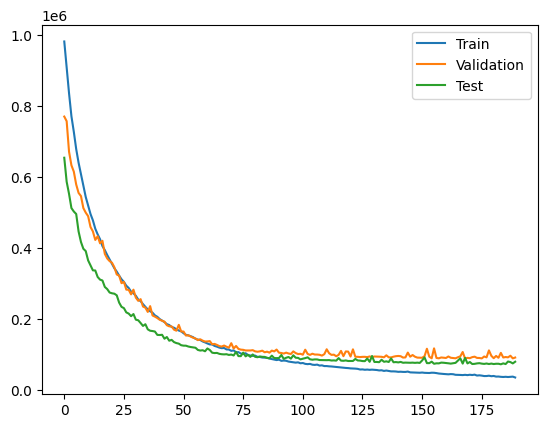

In [198]:
fig, ax = plt.subplots()

ax.plot(training.results['Train'], label='Train')
ax.plot(training.results['Validation'], label='Validation')
ax.plot(training.results['Test'], label='Test')
ax.legend()

## Evaluation and plotting classes

In [199]:
class OSAEvaluator:
    
    def evaluate_OSA(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            y_pred = model(src, tgt)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        return Y_real, Y_pred
            
class FSEvaluator:
    
    def evaluate_FS(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        tgt_sim = None
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            if tgt_sim is None:
                tgt_sim = tgt
            else:
                tgt_sim[:-1,:] = tgt_sim[1:,:]
                tgt_sim[-1,:] = y_pred
            y_pred = model(src, tgt_sim)
            Y_real.append(y_real.reshape(1,-1))
            Y_pred.append(y_pred)
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        return Y_real, Y_pred
    
class Evaluator(OSAEvaluator, FSEvaluator):
    
    pass
        

In [200]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(dataset, model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(dataset, model)

100%|██████████| 699/699 [00:03<00:00, 209.03it/s]


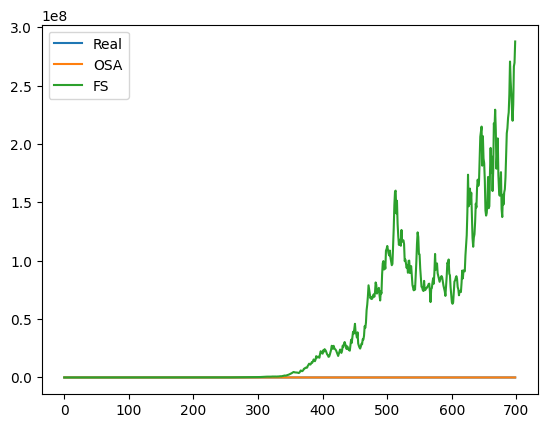

In [201]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()